# Funkcje Pomocnicze do Zadania

Aby wszystkie funkcje zadziałały, notebook powinien być uruchamiany z następującym ułożeniem katalogów:

```
|- helpers.ipynb
|- sampleSubmission.csv
|- train
 |- {unzipped train files and labels}
|- test
 |- {unzipped test files}
```

Należy odkomentować u siebie linijki zapisujące pliki.

In [1]:
# !conda install -c conda-forge -y librosa

In [2]:
import os

import librosa
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import roc_auc_score
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm, trange

SEED = 20124
torch.manual_seed(SEED)
np.random.seed(SEED)

# Wczytywanie Danych

Poniższe funkcje są przykładowymi funkcjami wczytującymi dane. Możliwe, że będą potrzebne modyfikacje reprezentacji i bardziej skomplikowana funkcja tworząca zbiór treningowy. Wczytywanie danych nie jest zaimplementowane optymalnie - między innymi kod wczytuje wielokrotnie ten sam plik. Dla bardziej złożonych reprezentacji możliwe, że trzeba będzie przepisać te funkcje.

In [3]:
def load_mel(file_name, start=0, stop=None, n_mels=60):
    '''Wczytuje mel spektrogram z pliku.
    
    Args:
        file_name (str): Nazwa pliku z nagraniem.
        start (float): Sekunda, w której zaczyna się interesujący fragment.
        stop (float): Sekunda, w której kończy się interesujący fragment.
        n_mels (int): Liczba meli na spektrogramie (wysokość spektrogramu).
    
    Returns:
        ndarray: Spektrogram.
    '''
    samples, sample_rate = librosa.core.load(file_name, sr = None)
    samples = samples[int(start * sample_rate):int(stop * sample_rate) if stop else None]
    spectrogram = librosa.feature.melspectrogram(y = samples, sr = sample_rate,
                                                 n_mels = n_mels, fmin = 4000, fmax = 9500)
    return spectrogram


def load_spec(file_name, start=0, stop=None):
    '''Wczytuje standardowy spektrogram z pliku.
    
    Args:
        file_name (str): Nazwa pliku z nagraniem.
        start (float): Sekunda, w której zaczyna się interesujący fragment.
        stop (float): Sekunda, w której kończy się interesujący fragment.
    
    Returns:
        ndarray: Spektrogram.
    '''
    sample_rate, samples = wavfile.read(file_name)
    samples = samples[int(start * sample_rate):int(stop * sample_rate) if stop else None]
    _, _, spectrogram = signal.spectrogram(samples, sample_rate)
    return spectrogram


def load_test(load_repr=load_mel):
    '''Wczytuje dane testowe.
    
    Args:
        load_repr (function): Funkcja wczytująca pożądaną reprezentację.
    
    Returns:
        ndarray: Tablica z danymi testowymi.
    '''
    with open('sampleSubmission.csv', 'r') as file:
        lines = file.read().split()[1:]
        sample_ids = [line.split(',')[0] for line in lines]
        samples = np.array([s.split('/') for s in sample_ids])
    
    X_test = []
    rec_files = sorted([file_name for file_name in os.listdir('test') 
                        if file_name.endswith('.wav')], key=lambda x: int(x.split('.')[0][3:]))
    for file_name in rec_files:
        recording_id = file_name.split('.')[0][3:]
        time_markers = samples[samples[:, 0] == recording_id, 1].astype(np.int)
        for t in time_markers:
            representation = load_repr(os.path.join('test', file_name), start = t, stop = t + 1)
            X_test.append(representation)
    return np.array(X_test)


def read_labels():
    '''Wczytuje etykiety czasowe z pliku labels.txt w folderze train.
    
    Returns:
        ndarray: Tablica z etykietami czasowymi zawierająca kolumny: nr nagrania, sekunda początku dźwięku, sekunda końca dźwięku.
    '''
    labels = []
    with open(os.path.join('train', 'labels.txt'), 'r') as file:
        text = file.read()
        for line in text.split('\n')[1:]:
            if len(line) > 1:
                rec, start, stop = line.split(',')
                rec, start, stop = int(rec[3:]), float(start), float(stop)
                labels.append([rec, start, stop])
    return np.array(labels)


def check_voices(second, labels, tol=0.):
    '''Sprawdza czy w ramce czasowej [second, second+1] znajduje się głos według etykiet `labels`.
    
    Args:
        second (float): Sekunda nagrania.
        labels (ndarray): Tablica z etykietami, której 2 kolumna oznacza początek, a 3-cia - koniec nagrania.
        tol (float): Tolerancja na brzegach fragmentu. Dźwięk, żeby był uznany, musi się kończyć po czasie `second+tol`
            lub zaczynać przed czasem `second+1-tol`.
    Returns:
        bool: Czy w ramce czasowej jest odgłos ptaka.
    '''
    return (labels[1] >= second and labels[1] < second + 1 - tol) or \
           (labels[2] < second + 1 and labels[2] > second + tol) or \
           (labels[1] < second and labels[2] > second + 1)


def map_seconds_to_y(labels):
    '''Tworzy etykiety dla każdej kolejnej sekundy 10-sekundowego nagrania. -1 oznacza niepewną etykietę (urwane dźwięki na brzegach).
    
    Args:
        labels (ndarray): Tablica z etykietami, której 2 kolumna oznacza początek, a 3-cia - koniec nagrania.
    Returns:
        ndarray: Tablica z binarnymi etykietami dla każdej z 10 sekund z możliwą niepewną etkietą -1.
    '''
    y = [0] * 10
    y_restrictive = [0] * 10
    for s in range(10):
        for l in labels:
            if check_voices(s, l):
                y[s] = 1
            if check_voices(s, l, 0.02):
                y_restrictive[s] = 1
        if y[s] != y_restrictive[s]:
            y[s] = -1
    return y


def load_train(load_repr=load_mel):
    '''Wczytuje dane treningowe.
    
    Args:
        load_repr (function): Funkcja wczytująca pożądaną reprezentację.
    
    Returns:
        (ndarray, ndarray): Tablica z danymi treningowymi, tablica z binarnymi etykietami treningowymi.
    '''
    labels = read_labels()
    X_train, y_train = [], []
    rec_files = [file_name for file_name in os.listdir('train') if file_name.endswith('.wav')]
    for file_name in rec_files:
        recording_id = int(file_name.split('.')[0][3:])
        recording_labels = labels[labels[:, 0] == recording_id]
        y_binary = map_seconds_to_y(recording_labels)
        for i, y in enumerate(y_binary):
            if y != -1:
                try:
                    representation = load_repr(os.path.join('train', file_name), start = i, stop = i + 1)
                    X_train.append(representation)
                    y_train.append(y)
                except ValueError:
                    print('Error reading file', file_name)
                except TypeError:
                    print('Unsupported type', file_name)
    return np.array(X_train), np.array(y_train)

# Zapisywanie Wczytanej Reprezentacji

Ponieważ tworzenie reprezentacji może zabierać sporo czasu (szczególnie w tak naiwnej implementacji jak powyższa), warto zapisać wczytane dane do plików.

In [4]:
# Poniższa linijka ustawia folder główny
# os.chdir('../input/')

X_test = load_test()
np.save(os.path.join('test', 'tmp_X_test'), X_test)

X, y = load_train()
np.save(os.path.join('train', 'tmp_X_train'), X)
np.save(os.path.join('train', 'tmp_y_train'), y)

# Model i Trenowanie

Poniższy przykład używa poprawnych metryk i zapisuje parametry modelu.

In [6]:
class BirdDetector(torch.nn.Module):
    
    def __init__(self):
        super(BirdDetector, self).__init__()
        self.pool = torch.nn.MaxPool2d(2)
        
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(64)
        
        self.conv2 = torch.nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(32)
        
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(16)
        
        self.fc1 = torch.nn.Linear(1120, 500) #128*15*2
        self.fc2 = torch.nn.Linear(500, 2)
        
        self.sigmoid = torch.nn.Sigmoid()
            
    def forward(self, x):
        
        out = self.pool(self.bn1(torch.relu(self.conv1(x))))
        out = self.pool(self.bn2(torch.relu(self.conv2(out))))
        out = self.pool(self.bn3(torch.relu(self.conv3(out))))
        
        out = out.view(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.fc2(out)
        
        return self.sigmoid(out)
    
model = BirdDetector()

In [7]:
# Dzielenie zbioru danych na treningowy i walidacyjny
split_point = int(len(X) * 0.8)

X_train = torch.Tensor(X[:split_point])
y_train = torch.LongTensor(y[:split_point])

X_valid = torch.Tensor(X[split_point:])
y_valid = torch.LongTensor(y[split_point:])

batch_size = 64

dataset = TensorDataset(X_train, y_train)
data_loader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

valid_dataset = TensorDataset(X_valid, y_valid)
valid_data_loader = DataLoader(valid_dataset, batch_size = batch_size)

In [8]:
# Ustawienie kosztu i optimizera
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Pętla uczenia
best_preds, best_score = None, 0.
losses, scores = [], []
for epoch in trange(30):
    running_loss = 0
    model.train()
    for x, y in data_loader:
        optimizer.zero_grad()

        outputs = model(x.view(-1, 1, x.shape[1], x.shape[2]))
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    losses.append(running_loss)
    
    model.eval()
    preds = []
    for x, _ in valid_data_loader:
        out = model(x.view(-1, 1, x.shape[1], x.shape[2]))
        preds.append(torch.softmax(out, dim = 1)[:, 1].detach().numpy())
    preds = np.concatenate(preds, axis = 0)
    
    # Metryką testującą jest ROC AUC
    score = roc_auc_score(y_valid.numpy(), preds)
    scores.append(score)
    print(score)
    if score > best_score:
        best_score = score
        best_preds = preds
        np.save('tmp_preds', best_preds)
        
        # Model dający najlepszy wynik powinien być zapisany
        torch.save(model.state_dict(), 'tmp_model.pt')

  3%|▎         | 1/30 [00:52<25:18, 52.36s/it]

0.569420671494


  7%|▋         | 2/30 [01:42<24:09, 51.76s/it]

0.624325213957


 10%|█         | 3/30 [02:32<23:00, 51.13s/it]

0.586899275839


 13%|█▎        | 4/30 [03:20<21:45, 50.21s/it]

0.525510204082


 17%|█▋        | 5/30 [04:10<20:54, 50.16s/it]

0.600806451613


 20%|██        | 6/30 [04:59<19:57, 49.90s/it]

0.602271231073


 23%|██▎       | 7/30 [05:47<18:51, 49.21s/it]

0.506731402238


 27%|██▋       | 8/30 [06:35<17:53, 48.79s/it]

0.690569453588


 30%|███       | 9/30 [07:23<16:59, 48.54s/it]

0.540816326531


 33%|███▎      | 10/30 [08:10<16:05, 48.27s/it]

0.55612244898


 37%|███▋      | 11/30 [08:58<15:14, 48.12s/it]

0.515306122449


 40%|████      | 12/30 [09:46<14:24, 48.05s/it]

0.691548716261


 43%|████▎     | 13/30 [10:34<13:38, 48.17s/it]

0.520408163265


 47%|████▋     | 14/30 [11:22<12:49, 48.11s/it]

0.515306122449


 50%|█████     | 15/30 [12:10<11:58, 47.90s/it]

0.515306122449


 53%|█████▎    | 16/30 [12:57<11:08, 47.77s/it]

0.5


 57%|█████▋    | 17/30 [13:45<10:20, 47.76s/it]

0.515306122449


 60%|██████    | 18/30 [14:33<09:32, 47.70s/it]

0.510204081633


 63%|██████▎   | 19/30 [15:20<08:44, 47.71s/it]

0.55612244898


 67%|██████▋   | 20/30 [16:08<07:57, 47.73s/it]

0.658064516129


 70%|███████   | 21/30 [16:56<07:09, 47.76s/it]

0.515306122449


 73%|███████▎  | 22/30 [17:43<06:21, 47.65s/it]

0.555579328506


 77%|███████▋  | 23/30 [18:32<05:36, 48.04s/it]

0.580307768269


 80%|████████  | 24/30 [19:21<04:49, 48.22s/it]

0.572021066491


 83%|████████▎ | 25/30 [20:10<04:02, 48.40s/it]

0.587393021725


 87%|████████▋ | 26/30 [20:59<03:14, 48.58s/it]

0.571428571429


 90%|█████████ | 27/30 [21:48<02:26, 48.75s/it]

0.535714285714


 93%|█████████▎| 28/30 [22:37<01:37, 48.72s/it]

0.520408163265


 97%|█████████▋| 29/30 [25:37<01:28, 88.15s/it]

0.545918367347


100%|██████████| 30/30 [26:25<00:00, 76.22s/it]

0.510204081633


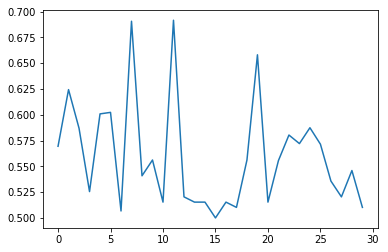

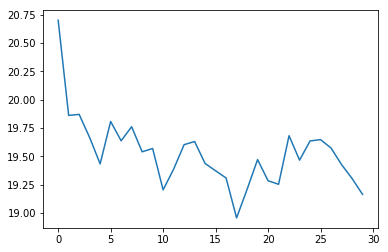

In [9]:
# Rysowanie lossu i AUC

import matplotlib.pyplot as plt

%matplotlib inline

plt.plot(scores)
plt.show()

plt.plot(losses)
plt.show()

# Zapis Predykcji

In [10]:
def save_predictions(preds):
    '''Zapisuje predykcje do pliku zgodnego z formatem odpowiedzi.
    
    Args:
        preds (list): Lista predykcji (prawdopodobieństw).
    '''
    with open('sampleSubmission.csv', 'r') as file:
        submission_text = file.read().split()
        header = submission_text[0]
        lines = submission_text[1:]

    output_lines = [header]
    for pred, line in zip(preds, lines):
        output_lines.append("{},{}".format(line.split(',')[0], pred))
    
    with open('mySubmission.csv', 'w') as file:
        file.write('\n'.join(output_lines) + '\n')

In [11]:
# Wczytanie najlepszego modelu
model.load_state_dict(torch.load('tmp_model.pt'))

# Tworzenie data loadera testowego
X_test_tensor = torch.Tensor(X_test)

test_dataset = TensorDataset(X_test_tensor)
test_data_loader = DataLoader(test_dataset, batch_size = batch_size)

# Ewaluacja modelu na danych testowych
model.eval()
preds = []
for x in test_data_loader:
    out = model(x[0].view(-1, 1, x[0].shape[1], x[0].shape[2]))
    preds.append(torch.softmax(out, dim = 1)[:, 1].detach().numpy())
preds = np.concatenate(preds, axis = 0)

# Zapisanie predykcji do poprawnego formatu
save_predictions(preds)